0th epoch starting.
1th epoch starting.
2th epoch starting.
3th epoch starting.
4th epoch starting.
5th epoch starting.
6th epoch starting.
7th epoch starting.
8th epoch starting.
9th epoch starting.
Time ellapsed in training is: 63.605716705322266
---------------------
10.422374729761481 6.172500033003813
---------------------
threshold:  28.939874828772922
Type 1 Error: 0.8900 %
Type 2 Error: 4.2800 % 


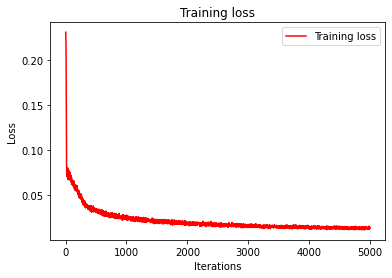

In [10]:
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import save_image


import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')

lr = 0.001
batch_size = 100
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
Step 1:
'''

# MNIST dataset
dataset = datasets.MNIST(root='./mnist_data/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False, 
                              transform=transforms.ToTensor())

# KMNIST dataset, only need test dataset
anomaly_dataset = datasets.KMNIST(root='./kmnist_data/',
                              train=False, 
                              transform=transforms.ToTensor(),
                              download=True)

# print(len(train_dataset))  # 50000
# print(len(validation_dataset))  # 10000
# print(len(test_dataset))  # 10000
# print(len(anomaly_dataset))  # 10000

'''
Step 2: AutoEncoder
'''
# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = F.relu(self.fc3(x))
        return z

# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        x = F.sigmoid(self.fc3(z))  # to make output's pixels are 0~1
        x = x.view(x.size(0), 1, 28, 28) 
        return x
    
'''
Step 3: Instantiate model & define loss and optimizer
'''
enc = Encoder().to(device)
dec = Decoder().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)


'''
Step 4: Training
'''
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


train_loss_list = []

import time
start = time.time()
for epoch in range(epochs) :
    print("{}th epoch starting.".format(epoch))
    enc.train()
    dec.train()
    for batch, (images, _) in enumerate(train_loader) :
        images = images.to(device)
        z = enc(images)
        reconstructed_images = dec(z)
        
        optimizer.zero_grad()
        train_loss = loss_function(images, reconstructed_images)
        train_loss.backward()
        train_loss_list.append(train_loss.item())

        optimizer.step()

        print(f"[Epoch {epoch:3d}] Processing batch #{batch:3d} reconstruction loss: {train_loss.item():.6f}", end='\r')
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))

# plotting train loss
plt.plot(range(1,len(train_loss_list)+1), train_loss_list, 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

enc.eval()
dec.eval()

'''
Step 5: Calculate standard deviation by using validation set
'''
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)

def score_function(true_image, reconstructed_image):

    return torch.linalg.norm(true_image - reconstructed_image) **2


score_list = []
for images, _ in validation_loader:

    enc.eval()
    dec.eval()

    for idx in range(batch_size):
      
      image = images[idx].to(device)
      z = enc(image)
      reconstructed_image = dec(z)
      score = score_function(image, reconstructed_image)

      score_list.append(score.item())
    
print("---------------------")


mean = np.mean(score_list)
std = np.std(score_list)
print(mean, std)
print("---------------------")

threshold = mean + 3 * std
print("threshold: ", threshold)


'''
Step 6: Anomaly detection (mnist)
'''
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

cnt_all_MNIST, cnt_error_MNIST = 0, 0
for images, _ in test_loader:
    for idx in range(batch_size):
      image = images[idx].to(device)
      z = enc(image)
      reconstructed_image = dec(z)
      score = score_function(image.unsqueeze(0), reconstructed_image)

      score = score.item()
      cnt_all_MNIST += 1
      if score > threshold :
          cnt_error_MNIST += 1

print(f"Type 1 Error: {100 * cnt_error_MNIST/cnt_all_MNIST:.4f} %")

'''
Step 7: Anomaly detection (kmnist)
'''
anomaly_loader = torch.utils.data.DataLoader(dataset=anomaly_dataset, batch_size=batch_size)

cnt_all_KMNIST, cnt_error_KMNIST = 0, 0
for images, _ in anomaly_loader:
    for idx in range(batch_size):
      image = images[idx].to(device)
      z = enc(image)
      reconstructed_image = dec(z)
      score = score_function(image.unsqueeze(0), reconstructed_image)

      score = score.item()
      cnt_all_KMNIST += 1
      if score < threshold:
          cnt_error_KMNIST += 1

print(f"Type 2 Error: {100 * cnt_error_KMNIST / cnt_all_KMNIST:.4f} % ")
